# Bitcoin Currency Prediction
## with ARIMA

### Step 1: Import Libraries & Configuring Settings

In [1]:
pip install pandas numpy matplotlib statsmodels pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuring matplotlib settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)

Explanation:
- Start by importing necessary libraries and configuring the notebook.

### Step 2: Load and Prepare the Data

In [11]:
# Load data
data = pd.read_csv('coin_Bitcoin.csv')
data.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2991 non-null   int64  
 1   Name       2991 non-null   object 
 2   Symbol     2991 non-null   object 
 3   Date       2991 non-null   object 
 4   High       2991 non-null   float64
 5   Low        2991 non-null   float64
 6   Open       2991 non-null   float64
 7   Close      2991 non-null   float64
 8   Volume     2991 non-null   float64
 9   Marketcap  2991 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 233.8+ KB


In [13]:
# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set date as index
data.set_index('Date', inplace=True)

# Check for missing values
data.isnull().sum()

# Fill missing values (if any)
data.fillna(method='ffill', inplace=True)

Explanation:
- Read the CSV file containing Bitcoin data.
- Display first few rows of the dataset.
- Convert the 'Date' column to datetime format.
- Set the 'Date' column as the index for easy time-series manipulation.
- Check for and fill any missing values using forward fill method.

### Step 3: Plot the Original Time Series

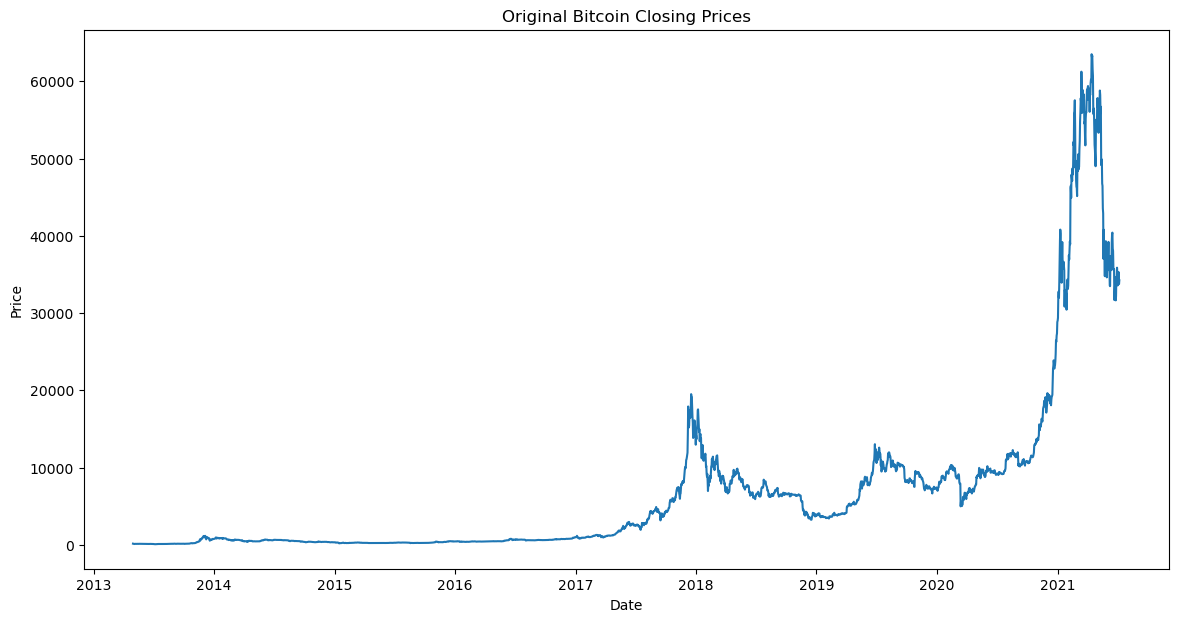

In [14]:
# Plot the original time series
plt.figure(figsize=(14, 7))
plt.plot(data['Close'])
plt.title('Original Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Explanation:
- Plot the original Bitcoin closing prices to visualize the data.
- This gives an overview of the time-series data we are working with.

### Step 4: Check for Stationarity and Differencing

In [15]:
# Check for stationarity
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -0.797310
p-value                           0.819911
#Lags Used                       29.000000
Number of Observations Used    2961.000000
Critical Value (1%)              -3.432560
Critical Value (5%)              -2.862517
Critical Value (10%)             -2.567290
dtype: float64


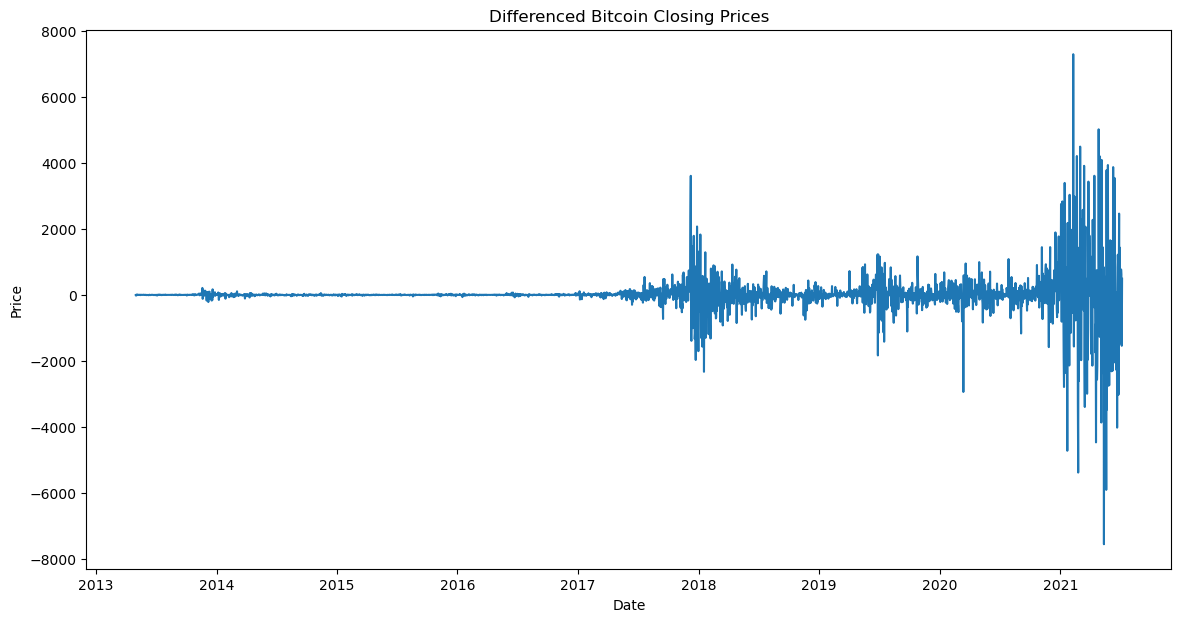

Results of Dickey-Fuller Test:
Test Statistic                -8.912361e+00
p-value                        1.095586e-14
#Lags Used                     2.800000e+01
Number of Observations Used    2.961000e+03
Critical Value (1%)           -3.432560e+00
Critical Value (5%)           -2.862517e+00
Critical Value (10%)          -2.567290e+00
dtype: float64


In [16]:
# Differencing to make the data stationary
data['Close_diff'] = data['Close'] - data['Close'].shift(1)
data['Close_diff'].dropna(inplace=True)

# Plot differenced data
plt.figure(figsize=(14, 7))
plt.plot(data['Close_diff'])
plt.title('Differenced Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Check stationarity again after differencing
test_stationarity(data['Close_diff'].dropna())

Explanation:
- Define a function to perform the Dickey-Fuller test for stationarity.
- Test the original data for stationarity.
- Apply differencing to make the data stationary if necessary.
- Plot the differenced data.
- Test the differenced data for stationarity.

### Step 5: Plot ACF and PACF

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


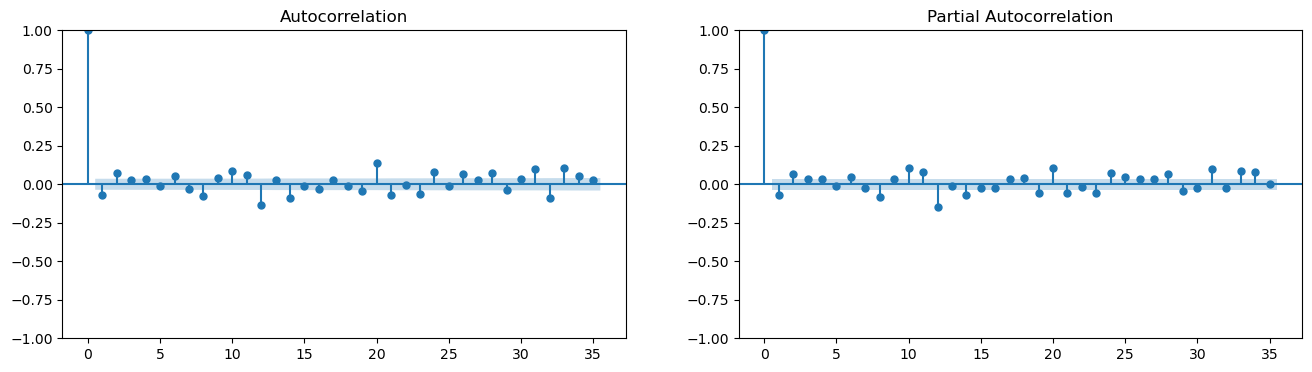

In [17]:
# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data['Close_diff'].dropna(), ax=ax[0])
plot_pacf(data['Close_diff'].dropna(), ax=ax[1])
plt.show()

Explanation:
- Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the differenced data.
- These plots help in understanding the autocorrelation in the time series and selecting appropriate ARIMA model parameters.

### Step 6:  Train-Test Split

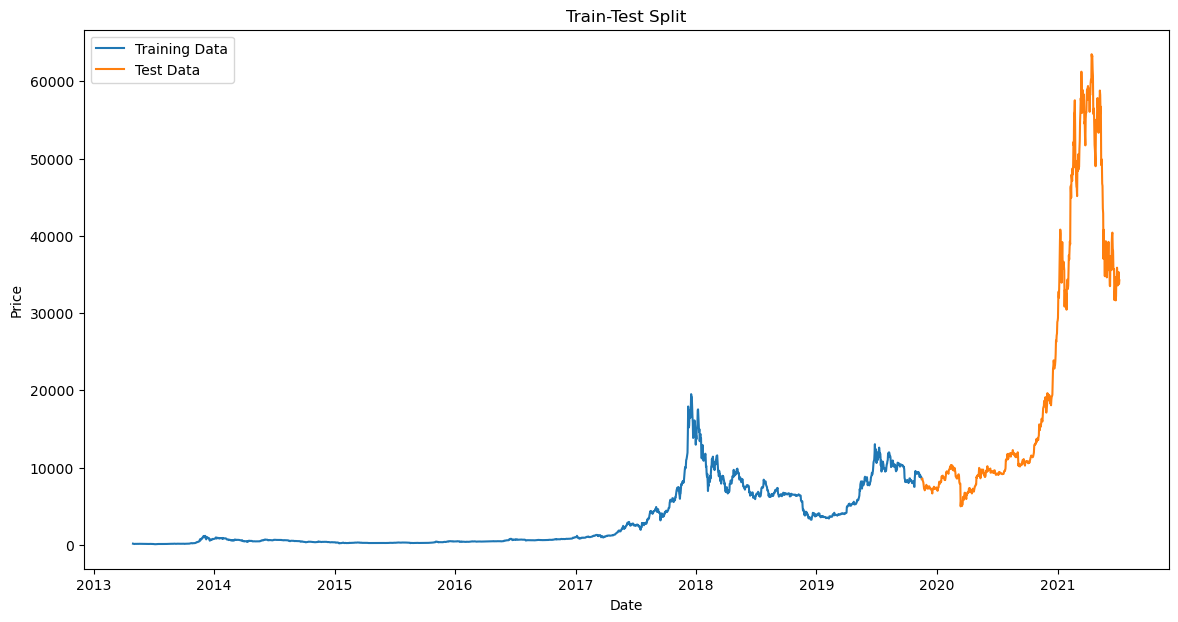

In [18]:
# Train-test split
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Plot train-test split
plt.figure(figsize=(14, 7))
plt.plot(train_data['Close'], label='Training Data')
plt.plot(test_data['Close'], label='Test Data')
plt.title('Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Explanation:
- Split the data into training and test sets (80% training, 20% testing).
- Plot the training and test data to visualize the split.

### Step 7: Model Selection & Training

In [19]:
# Use auto_arima to find the best SARIMA model parameters
model = auto_arima(train_data['Close'], seasonal=True, m=7)  # Adjust 'm' for seasonality

# Fit the SARIMA model
model.fit(train_data['Close'])

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

Explanation:
- Use auto_arima to automatically select the best SARIMA model parameters based on AIC.
- Fit the SARIMA model to the training data.

### Step 8: Model Evaluation & Forecasting

Mean Squared Error (MSE): 437327606.99690646


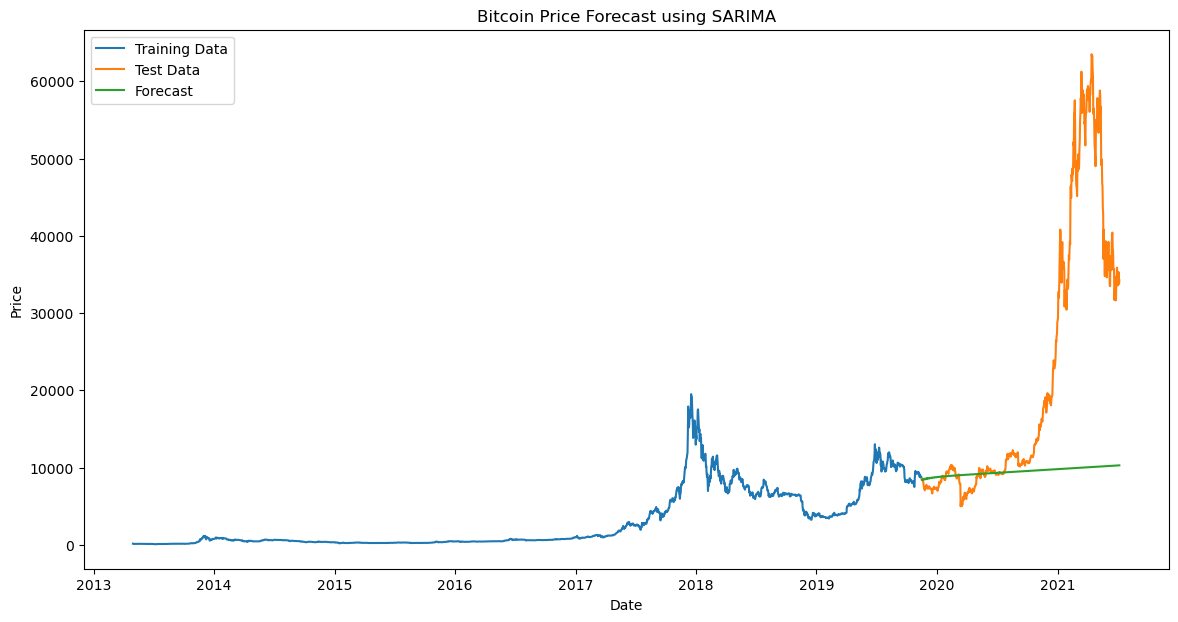

In [20]:
# Forecast
forecast = model.predict(n_periods=len(test_data))

# Convert forecast to a pandas Series with datetime index
forecast = pd.Series(forecast, index=test_data.index)

# Evaluate the model
mse = mean_squared_error(test_data['Close'], forecast)
print(f'Mean Squared Error (MSE): {mse}')

# Visualize the forecast vs. actual prices
plt.figure(figsize=(14, 7))
plt.plot(train_data['Close'], label='Training Data')
plt.plot(test_data['Close'], label='Test Data')
plt.plot(forecast, label='Forecast')
plt.title('Bitcoin Price Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Explanation:
- Forecast the Bitcoin prices for the test period.
- Convert the forecast to a pandas Series with the same index as the test data.
- Calculate and print the Mean Squared Error (MSE) to evaluate the model.
- Plot the training data, test data, and forecasted values to visualize the model's performance.

### Step 9: Plot Residuals

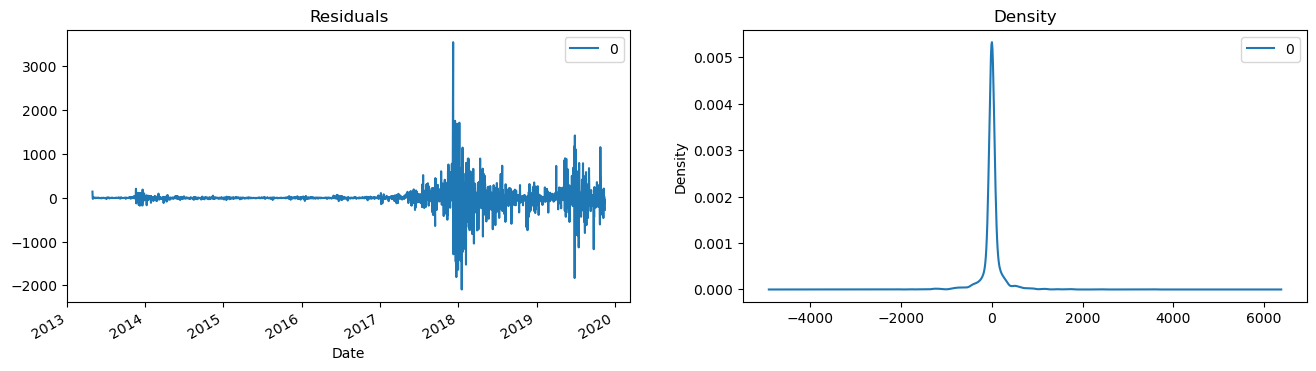

In [21]:
# Plot residuals
residuals = pd.DataFrame(model.resid())
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Explanation:
- Plot the residuals of the SARIMA model to check for randomness.
- A good model should have residuals that are randomly distributed around zero.